___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-1 (ANN)<br><br>Churn Prediction for Bank Customer<br><h1>

## Import  libraries & data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_auc_score,roc_curve
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import pickle
import warnings
import os
import optuna

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## Exploratory Data Analysis and Visualization

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.shape

(10000, 14)

In [5]:
df.isnull().sum().any()

False

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [8]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

Exited
0    7963
1    2037
Name: count, dtype: int64


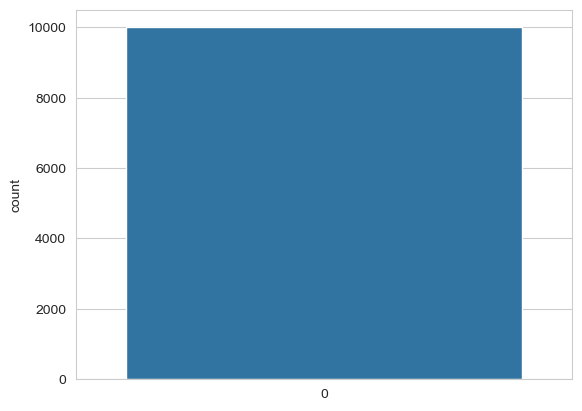

In [9]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

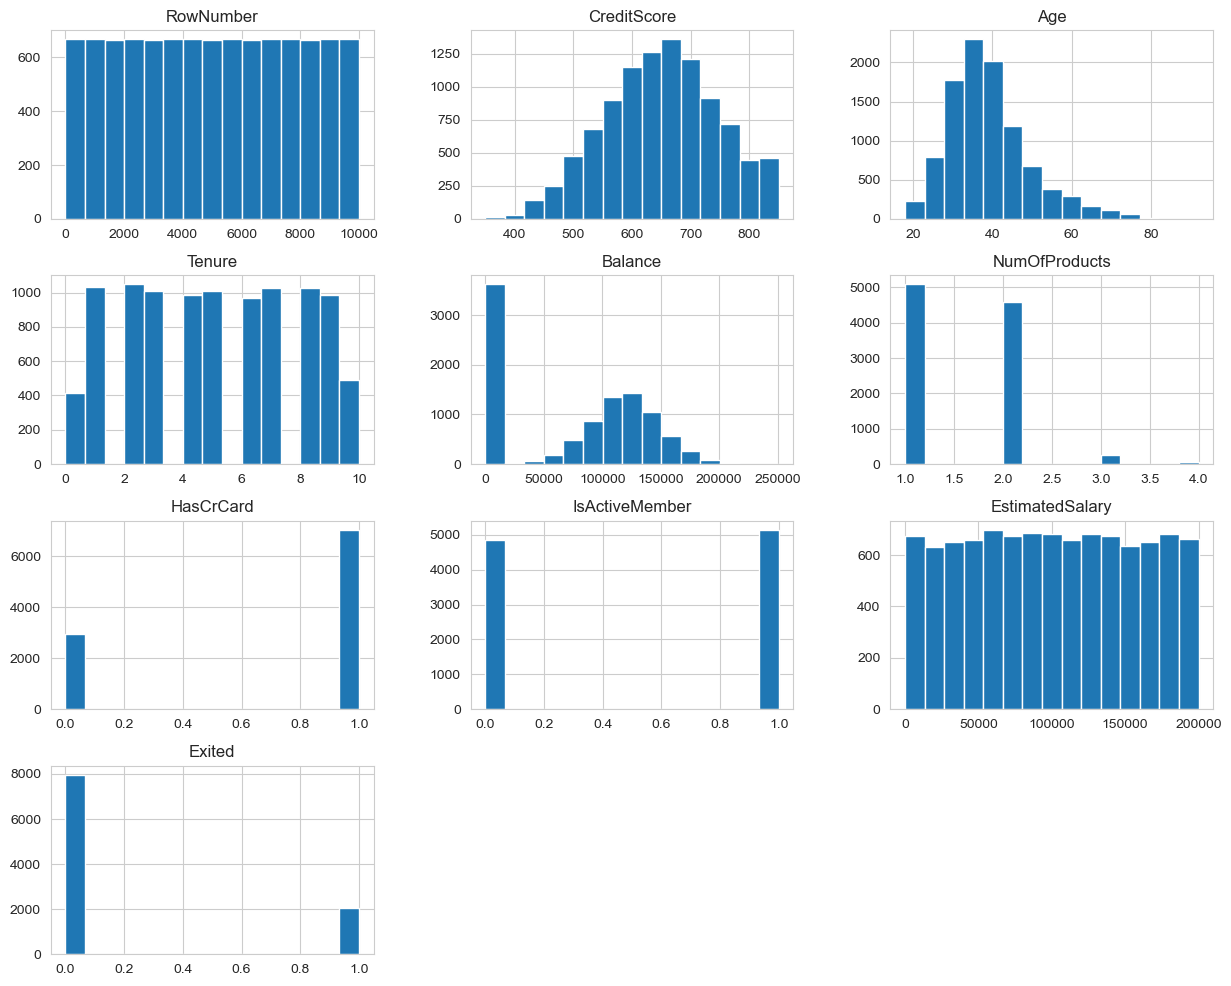

In [10]:
df.hist(figsize=(15, 12), bins=15);


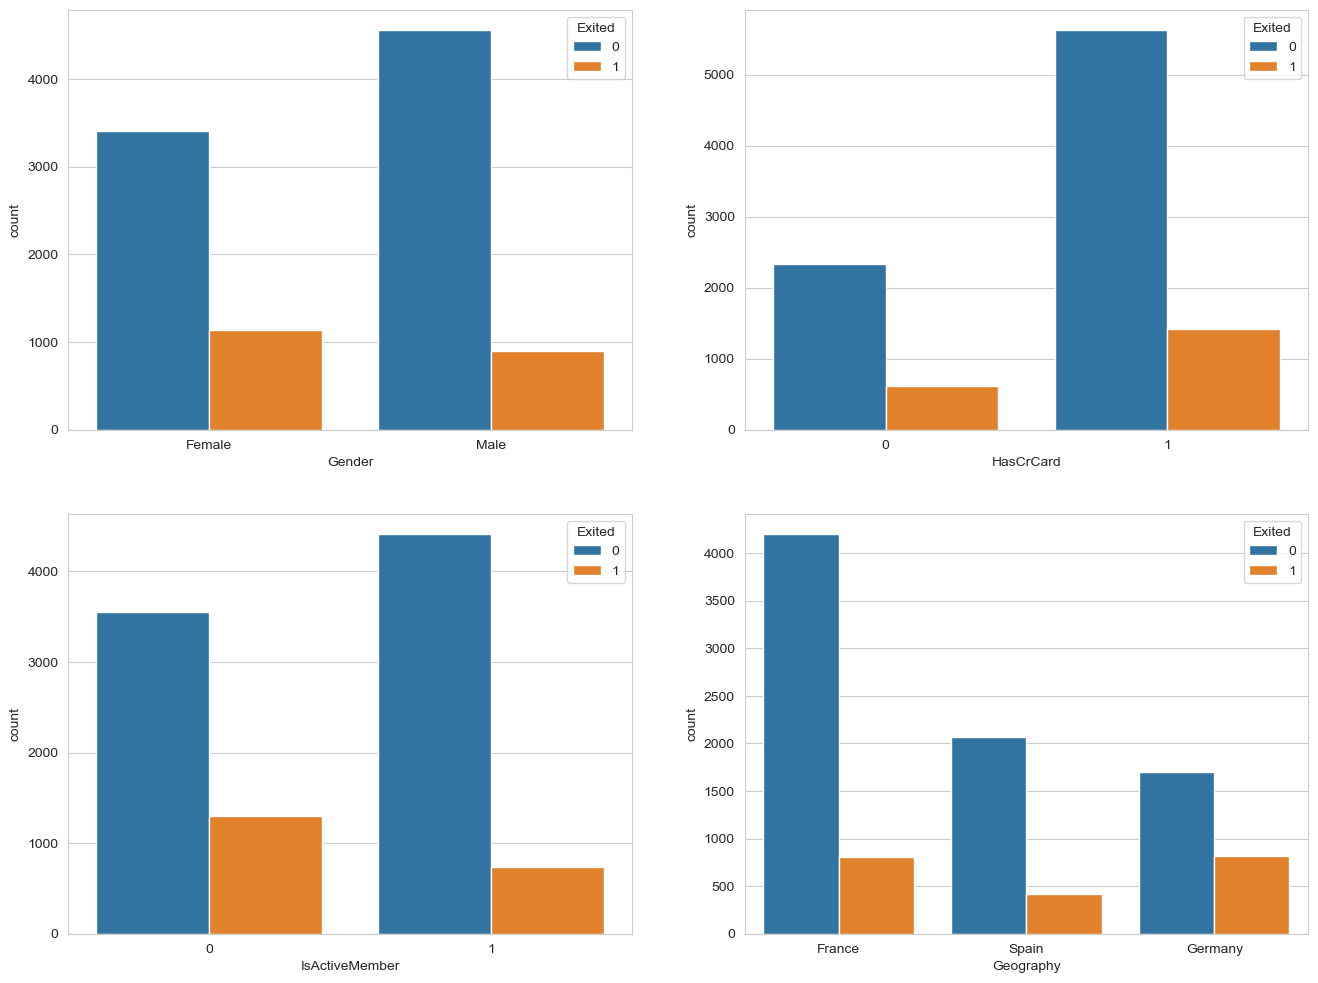

In [11]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

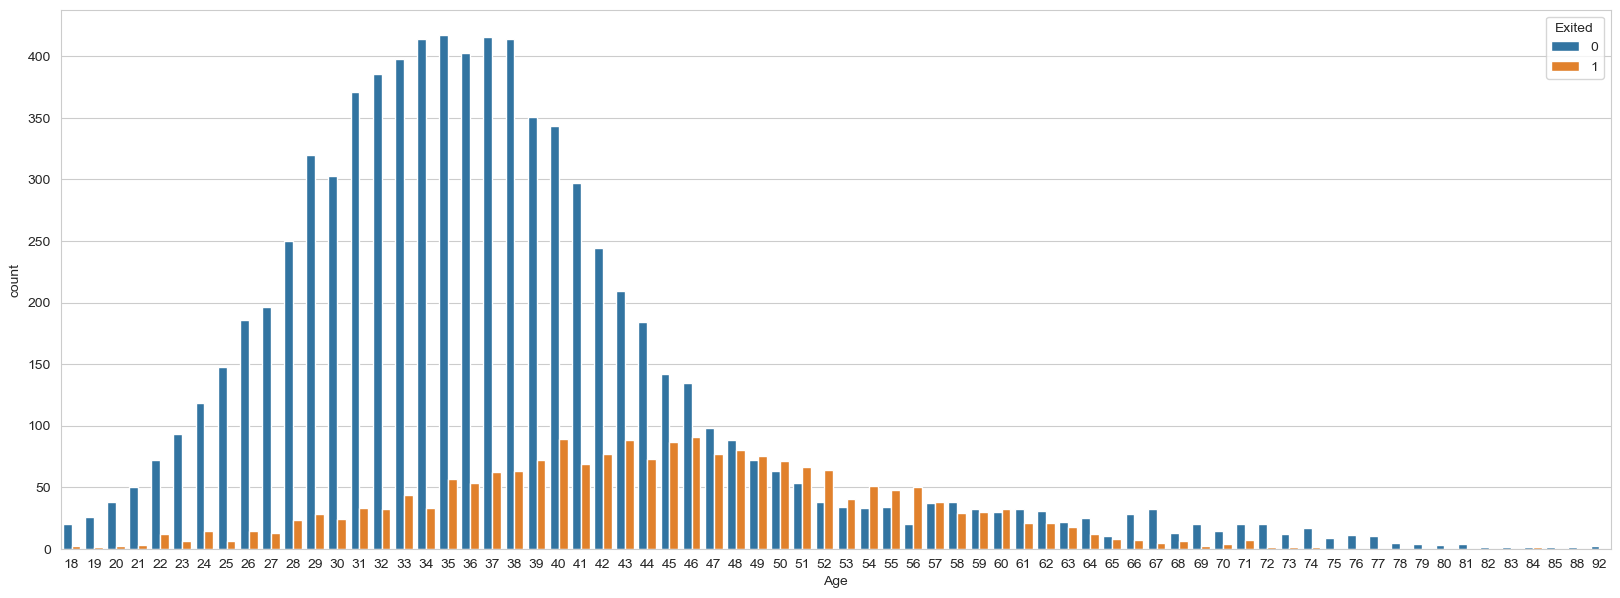

In [12]:
plt.figure(figsize=(20, 7))
sns.countplot(x='Age', hue='Exited', data=df)
plt.show()

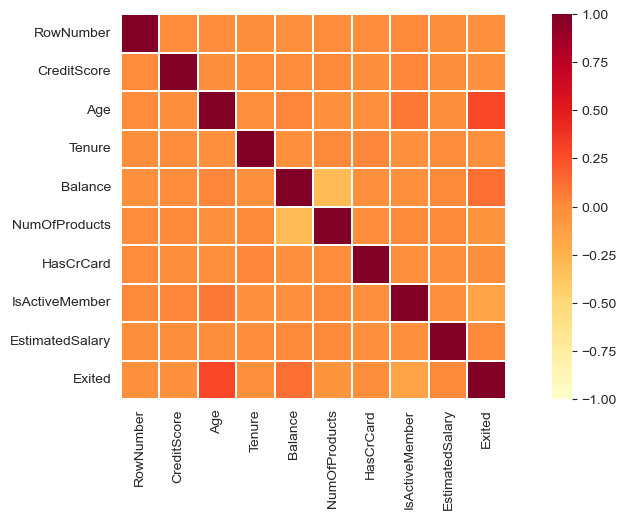

In [13]:
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'YlOrRd', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

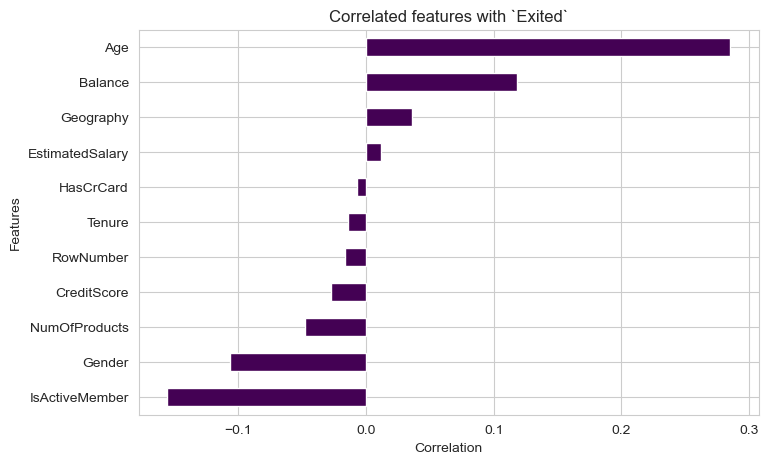

In [14]:

# Encode categorical variables to numeric values
label_encoder = LabelEncoder()
df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Calculate correlations with 'Exited' after converting categorical variables to numeric
correlation_data = df.corr()['Exited'][:-1].sort_values()

plt.figure(figsize=(8, 5))
correlation_data.plot(kind='barh', colormap='viridis')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlated features with `Exited`')
plt.show()


In [15]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,850,2,0,43,2,125510.82,1,1,1,79084.10,0


## Preprocessing of Data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [17]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=seed)


In [18]:
scaler = MinMaxScaler()


In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

### without class_weigth

In [20]:
X_train.shape

(9000, 11)

In [21]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

tf.random.set_seed(seed)

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [22]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=15)
#The patience is often set somewhere between 10 and 100 (10 or 20 is more common), 
#but it really depends on your dataset and network.

In [23]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 1s 5ms/step - loss: 0.6292 - recall: 0.1283 - val_loss: 0.5619 - val_recall: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.5248 - recall: 0.0000e+00 - val_loss: 0.4986 - val_recall: 0.0000e+00
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4983 - recall: 0.0000e+00 - val_loss: 0.4839 - val_recall: 0.0000e+00
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4840 - recall: 0.0042 - val_loss: 0.4583 - val_recall: 0.0276
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4662 - recall: 0.0539 - val_loss: 0.4432 - val_recall: 0.1050
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4566 - recall: 0.0878 - val_loss: 0.4364 - val_recall: 0.0829
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4499 - recall: 0.1065 - val_loss: 0.4265 - val_recall: 0.1657
Epoch 8/200
64/64 [==

64/64 [==============================] - 0s 2ms/step - loss: 0.3543 - recall: 0.4159 - val_loss: 0.3105 - val_recall: 0.4586
Epoch 61/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3559 - recall: 0.4092 - val_loss: 0.3103 - val_recall: 0.4530
Epoch 62/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3538 - recall: 0.4153 - val_loss: 0.3163 - val_recall: 0.5414
Epoch 63/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3538 - recall: 0.4189 - val_loss: 0.3085 - val_recall: 0.4972
Epoch 64/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3540 - recall: 0.4122 - val_loss: 0.3080 - val_recall: 0.5138
Epoch 65/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3532 - recall: 0.4140 - val_loss: 0.3099 - val_recall: 0.4420
Epoch 66/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3545 - recall: 0.4044 - val_loss: 0.3126 - val_recall: 0.5028
Epoch 67/200
64/64 [===========================

64/64 [==============================] - 0s 2ms/step - loss: 0.3482 - recall: 0.4195 - val_loss: 0.3022 - val_recall: 0.5138
Epoch 120/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3482 - recall: 0.4231 - val_loss: 0.3018 - val_recall: 0.4751
Epoch 121/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3482 - recall: 0.4292 - val_loss: 0.3010 - val_recall: 0.5083
Epoch 122/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3478 - recall: 0.4262 - val_loss: 0.3002 - val_recall: 0.4972
Epoch 123/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3478 - recall: 0.4213 - val_loss: 0.3046 - val_recall: 0.5304
Epoch 124/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3481 - recall: 0.4249 - val_loss: 0.3025 - val_recall: 0.4530
Epoch 125/200
64/64 [==============================] - 0s 2ms/step - loss: 0.3477 - recall: 0.4243 - val_loss: 0.2995 - val_recall: 0.5138
Epoch 126/200
64/64 [====================

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
loss_df = pd.DataFrame(model.history.history)
loss_df.head()

,loss,recall,val_loss,val_recall
0,0.629157,0.128329,0.561882,0.000000
1,0.524811,0.000000,0.498649,0.000000
2,0.498295,0.000000,0.483853,0.000000
3,0.484014,0.004237,0.458271,0.027624
4,0.466172,0.053874,0.443179,0.104972


<Axes: >

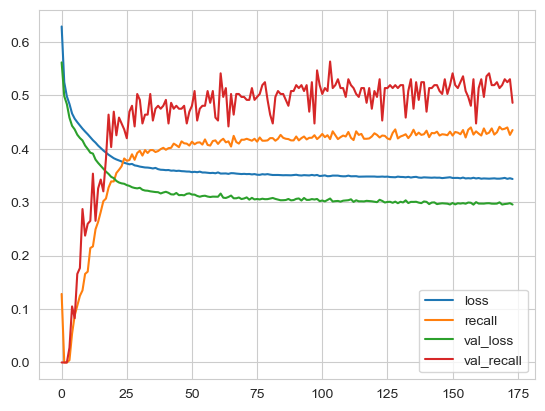

In [26]:
loss_df.plot()

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 1ms/step
[[772  24]
 [119  85]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       796
           1       0.78      0.42      0.54       204

    accuracy                           0.86      1000
   macro avg       0.82      0.69      0.73      1000
weighted avg       0.85      0.86      0.84      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

32/32 [==============================] - 0s 1ms/step


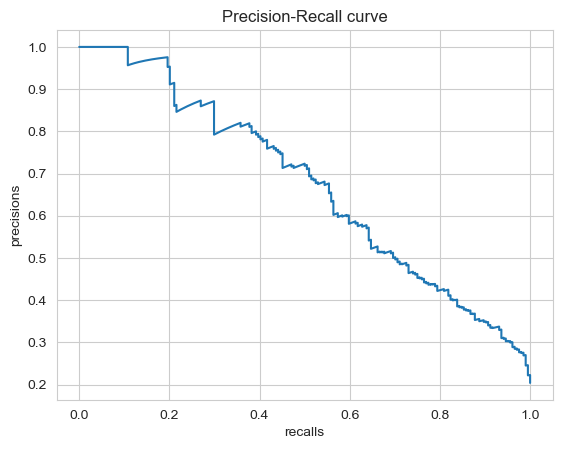

In [28]:
from sklearn.metrics import precision_recall_curve
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()
# roc curve, sınıflandırma performansını gösterir

In [29]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred_proba)

0.6736252874027479

### with class_weigth

In [30]:
model = Sequential()

tf.random.set_seed(seed)

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [31]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [ ]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop],
          class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.7205 - recall: 0.5278 - val_loss: 0.6981 - val_recall: 0.4917
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6922 - recall: 0.4897 - val_loss: 0.6842 - val_recall: 0.5249
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6799 - recall: 0.5248 - val_loss: 0.6542 - val_recall: 0.5083
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6631 - recall: 0.5720 - val_loss: 0.6053 - val_recall: 0.5193
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6439 - recall: 0.6144 - val_loss: 0.6358 - val_recall: 0.7072
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6262 - recall: 0.6616 - val_loss: 0.5796 - val_recall: 0.6409
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6131 - recall: 0.6695 - val_loss: 0.6039 - val_recall: 0.7403
Epoch 8/200
64/64 [======================

64/64 [==============================] - 0s 2ms/step - loss: 0.4809 - recall: 0.7470 - val_loss: 0.4264 - val_recall: 0.7845
Epoch 61/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4825 - recall: 0.7427 - val_loss: 0.4210 - val_recall: 0.7735
Epoch 62/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4789 - recall: 0.7554 - val_loss: 0.4936 - val_recall: 0.8343
Epoch 63/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4791 - recall: 0.7452 - val_loss: 0.4476 - val_recall: 0.8232
Epoch 64/200
64/64 [==============================] - 0s 2ms/step - loss: 0.4796 - recall: 0.7494 - val_loss: 0.4574 - val_recall: 0.8287
Epoch 65/200
 1/64 [..............................] - ETA: 0s - loss: 0.4919 - recall: 0.8148

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

In [ ]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()
# roc curve, sınıflandırma performansını gösterir

In [ ]:
average_precision_score(y_test, y_pred_proba)   #0.692983743350624

In [ ]:
from tensorflow.keras.optimizers import Adadelta, RMSprop, Nadam, Adam, SGD
def build_classifier(optimizer,learn_rate):
    classifier = Sequential()
    classifier.add(Dense(units=16, activation='relu'))
    classifier.add(Dense(units=8, activation='relu'))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer(learn_rate),
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [ ]:
class_weights

In [ ]:
from sklearn.model_selection import GridSearchCV

tf.random.set_seed(seed)

classifier = KerasClassifier(build_fn=build_classifier, epochs=200)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Nadam, Adadelta, SGD],
    'learn_rate': [0.001, 0.003, 0.005]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0)
#grid_model.fit(X_train,y_train, class_weight=class_weights)

In [ ]:
# Create a custom wrapper class
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, build_fn=None, learn_rate=0.001, **kwargs):
        self.learn_rate = learn_rate
        super(CustomKerasClassifier, self).__init__(build_fn=build_fn, **kwargs)
    
    def build_fn(self):
        return build_classifier(learn_rate=self.learn_rate)

# Create a CustomKerasClassifier instance
classifier = CustomKerasClassifier(epochs=200, batch_size=128)

# Define the parameters grid for grid search
parameters = {
    'learn_rate': [0.001, 0.003, 0.005],
    'batch_size': [128, 256]
}

In [ ]:
class_weights

In [ ]:


classifier = KerasClassifier(build_fn=build_classifier, epochs=200)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Nadam, Adadelta, SGD],
    'learn_rate': [0.001, 0.003, 0.005]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0)

In [ ]:
#grid_model.fit(X_train, y_train, class_weight=class_weights)

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

In [ ]:
#y_pred_proba = grid_model.predict(X_test)
#precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
#plt.plot(recalls, precisions, label='ANN')
#plt.xlabel('recalls')
#plt.ylabel('precisions')
#plt.title('Precision-Recall curve')
#plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

## Final Model and Model Deployment

In [ ]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [ ]:
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.003)

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop],
          batch_size=256,
          epochs=200,
          verbose=1,
          class_weight=class_weights)    
# {'batch_size': 256,'learn_rate': 0.003,'optimizer': keras.optimizer_v2.adam.Adam}
# pay attention!! validation data 

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print("loss : ", loss)
print("recall : ", recall)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
model.save('model_churn.h5')

### Prediction

In [ ]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

In [ ]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 11))
single_customer

In [ ]:
y_pred =(model.predict(single_customer) > 0.5).astype("int32")
y_pred

In [ ]:
df["Exited"].iloc[0]

## Comparison with ML

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_model=LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___